#### Import Necessary libraries

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import matplotlib.pyplot as plt
from datetime import date

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
import shap
import random

In [4]:
pd.options.display.max_rows = 120000
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from sklearn import preprocessing

#### Read data

In [5]:
encounters = pd.read_csv("train/encounters.csv")
patients = pd.read_csv("train/patients.csv")
conditions = pd.read_csv("train/conditions.csv")
observations = pd.read_csv('train/observations.csv')

In [6]:
encounters_test = pd.read_csv("test/test/encounters.csv")
patients_test = pd.read_csv("test/test/patients.csv")
conditions_test = pd.read_csv("test/test/conditions.csv")
observations_test = pd.read_csv('test/test/observations.csv')

In [7]:
covid_test = pd.read_csv('COVID_19 Status.csv').rename(columns = {'Id':'PATIENT'})

In [8]:
patients_test.Id.nunique()

29492

#### Function for preprocesing train data

In [9]:
def preprocess(encounters, patients, conditions, observations):
    covid_patients_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()
    inpatient = encounters[(encounters.REASONCODE==840539006) & (encounters.CODE == 1505002)].rename(columns = {'Id':'ENCOUNTER'})
    
    ##Change data type
    inpatient[['START','STOP']] = inpatient[['START','STOP']].astype('datetime64[ns]')
    patients[['BIRTHDATE','DEATHDATE']] = patients[['BIRTHDATE','DEATHDATE']].astype('datetime64[ns]')
    conditions[['START','STOP']] = conditions[['START','STOP']].astype('datetime64[ns]')
    inpatient['days_hospitalized'] = (inpatient['STOP']- inpatient['START']).astype('timedelta64[s]').astype(float)/86400
    
    ##join inpatients with patient data file 
    inpatient_df = pd.merge(inpatient, patients[['Id', 'BIRTHDATE', 'DEATHDATE','GENDER']],how='left' ,right_on = 'Id', left_on = 'PATIENT')
    inpatient_df.drop(['START','STOP','PAYER','DESCRIPTION','ENCOUNTERCLASS','CODE'], axis=1,inplace=True)
    df_inpatient_observation = pd.merge(inpatient_df, observations[['ENCOUNTER', 'PATIENT','DESCRIPTION','VALUE','UNITS']], on = ['ENCOUNTER', 'PATIENT'], how = 'left')
    df_inpatient_observation.sort_values('PATIENT', inplace = True)
    df_inpatient_observation['VALUE'] = pd.to_numeric(df_inpatient_observation['VALUE'], errors='coerce')
    
    #include top 20 occuring observation (only 11 features are present in test data)
    Avg_values = pd.DataFrame(df_inpatient_observation.groupby(['ENCOUNTER','PATIENT','DESCRIPTION'])['VALUE'].mean()).reset_index()
    test_include = pd.DataFrame(Avg_values.DESCRIPTION.value_counts().reset_index()).head(20)['index'].tolist()
    data_top_test = df_inpatient_observation[df_inpatient_observation['DESCRIPTION'].isin(test_include)].reset_index(drop=True)
    
    #Convert from long to wide format
    table = pd.pivot_table(data_top_test, values='VALUE', index=['ENCOUNTER','PATIENT'],
                    columns=['DESCRIPTION'], aggfunc=np.max).reset_index(drop = False)
    
    #Include Age as feature
    inpatient_df['BIRTHDATE'] = inpatient_df['BIRTHDATE'].astype('datetime64[ns]')
    inpatient_df['DEATHDATE'] = inpatient_df['DEATHDATE'].astype('datetime64[ns]')
    inpatient_df['AGE'] = np.where(inpatient_df['DEATHDATE'].dt.year.isna(), 2020-inpatient_df['BIRTHDATE'].dt.year, inpatient_df['DEATHDATE'].dt.year - inpatient_df['BIRTHDATE'].dt.year)
    
    #Merge observation with inpatient data
    inpatient_observation = pd.merge(table, inpatient_df[['ENCOUNTER', 'PATIENT','days_hospitalized','BIRTHDATE','DEATHDATE','GENDER','AGE']], on=['ENCOUNTER', 'PATIENT'], how='inner')
    inpatient_observation['Gender'] = np.where(inpatient_observation['GENDER']=='M',1,0)

    #Include only these condition code(out of these only 'Acute respiratory failure (disorder)':65710008 is found in test data)
    conditions_subset = [65710008, 770349000, 67782005, 132281000119108, 706870000, 389087006]
 
    covid_patient_conditions = conditions[(conditions.PATIENT.isin(
    covid_patients_ids)) & (conditions.CODE.isin(conditions_subset))].reset_index()    
    
    latest_date = pd.Series(['2020-05-26 00:00:00']*len(covid_patient_conditions))
    latest_date = pd.to_datetime(latest_date, infer_datetime_format=True)
    
    #count of days between STOP and START 
    covid_patient_conditions['condition_days'] = np.where(covid_patient_conditions.STOP.isna(), (latest_date-covid_patient_conditions['START']).astype('timedelta64[s]').astype(float)/86400,(covid_patient_conditions['STOP']-covid_patient_conditions['START']).astype('timedelta64[s]').astype(float)/86400)
    table_condition = pd.pivot_table(covid_patient_conditions, values='condition_days', index=['ENCOUNTER','PATIENT'],
                    columns=['DESCRIPTION']).reset_index(drop = False).fillna(0)
    
    #Merge with condition data
    Merge_condition = pd.merge(inpatient_observation, table_condition, on=['PATIENT','ENCOUNTER'], how='left').fillna(0)
    
    features = ['Gender','AGE']+table.drop(['PATIENT','ENCOUNTER'], axis=1).columns.tolist() + table_condition.drop(['PATIENT','ENCOUNTER'], axis=1).columns.tolist()
    return Merge_condition,features, table.drop(['PATIENT','ENCOUNTER'], axis=1).columns.tolist(), table_condition.drop(['PATIENT','ENCOUNTER'], axis=1).columns.tolist()

In [10]:
Merge_condition, features, observation_feature, condition_feature = preprocess(encounters, patients, conditions, observations)

#### Function for preprocessing test file

In [11]:
def preprocess_test_data(covid_test, observation_feature, condition_feature, encounters_test, patients_test, conditions_test, observations_test):
    covid_patients_ids = covid_test[covid_test['predicted']==True].PATIENT.unique()
    inpatient = encounters_test[(encounters_test['PATIENT'].isin(covid_patients_ids))].rename(columns = {'Id':'ENCOUNTER'})

    inpatient[['START','STOP']] = inpatient[['START','STOP']].astype('datetime64[ns]')
    patients_test[['BIRTHDATE','DEATHDATE']] = patients_test[['BIRTHDATE','DEATHDATE']].astype('datetime64[ns]')
    conditions_test[['START','STOP']] = conditions_test[['START','STOP']].astype('datetime64[ns]')
    patients_test.loc[:, 'COVERAGE_EXPENSE_RATIO'] = patients_test.apply(lambda x: x['HEALTHCARE_COVERAGE']/x['HEALTHCARE_EXPENSES'], axis = 1)

    ##join inpatients with patient data file 
    inpatient_df = pd.merge(inpatient, patients_test[['Id', 'BIRTHDATE', 'DEATHDATE','GENDER']],how='left' ,right_on = 'Id', left_on = 'PATIENT')
 
    inpatient_df.drop(['START','STOP','PAYER','DESCRIPTION','ENCOUNTERCLASS','CODE'], axis=1,inplace=True)
    df_inpatient_observation = pd.merge(inpatient_df, observations_test[['ENCOUNTER', 'PATIENT','DESCRIPTION','VALUE','UNITS']], on = ['ENCOUNTER', 'PATIENT'], how = 'left')
    df_inpatient_observation.sort_values('PATIENT', inplace = True)
    df_inpatient_observation['VALUE'] = pd.to_numeric(df_inpatient_observation['VALUE'], errors='coerce')
    
    #include top 20 occuring observation (only 11 features are present in test data)
    
    #Convert from long to wide format
    table = pd.pivot_table(df_inpatient_observation, values='VALUE', index=['PATIENT'],
                    columns=['DESCRIPTION'], aggfunc=np.max).reset_index(drop = False)
    table = table[list(set(df_inpatient_observation.DESCRIPTION.unique()) & set(observation_feature))+['PATIENT']]

    #Include Age as feature
    inpatient_df['BIRTHDATE'] = inpatient_df['BIRTHDATE'].astype('datetime64[ns]')
    inpatient_df['DEATHDATE'] = inpatient_df['DEATHDATE'].astype('datetime64[ns]')
    inpatient_df['AGE'] = np.where(inpatient_df['DEATHDATE'].dt.year.isna(), 2020-inpatient_df['BIRTHDATE'].dt.year, inpatient_df['DEATHDATE'].dt.year - inpatient_df['BIRTHDATE'].dt.year)
    
    #Merge observation with inpatient data
    inpatient_observation = pd.merge(table, inpatient_df[['PATIENT','BIRTHDATE','DEATHDATE','GENDER','AGE']], on=['PATIENT'], how='left')
    inpatient_observation['Gender'] = np.where(inpatient_observation['GENDER']=='M',1,0)
    inpatient_observation.drop_duplicates(inplace=True)

    #features = ['Gender','AGE']+table.drop(['PATIENT','ENCOUNTER'], axis=1).columns.tolist()
    
    #Include only these condition code(out of these only 'Acute respiratory failure (disorder)':65710008 is found in test data)
    conditions_subset = [65710008, 770349000, 67782005, 132281000119108, 706870000, 389087006]
 
    covid_patient_conditions = conditions_test[(conditions_test.PATIENT.isin(
    covid_patients_ids)) & (conditions_test.CODE.isin(conditions_subset))].reset_index()    

    latest_date = pd.Series(['2020-05-26 00:00:00']*len(covid_patient_conditions))
    latest_date = pd.to_datetime(latest_date, infer_datetime_format=True)
    
    #count of days between STOP and START 
    covid_patient_conditions['condition_days'] = np.where(covid_patient_conditions.STOP.isna(), (latest_date-covid_patient_conditions['START']).astype('timedelta64[s]').astype(float)/86400,(covid_patient_conditions['STOP']-covid_patient_conditions['START']).astype('timedelta64[s]').astype(float)/86400)
    table_condition = pd.pivot_table(covid_patient_conditions, values='condition_days', index=['PATIENT'],
                    columns=['DESCRIPTION']).reset_index(drop = False).fillna(0)

    #Merge with condition data
    Merge_condition = pd.merge(inpatient_observation, table_condition, on=['PATIENT'], how='left').fillna(0)
    features = ['Gender','AGE']+table.drop(['PATIENT'], axis=1).columns.tolist() + table_condition.drop(['PATIENT'], axis=1).columns.tolist()
    return Merge_condition,features, table.drop(['PATIENT'], axis=1).columns.tolist(), table_condition.drop(['PATIENT'], axis=1).columns.tolist()

Split train and test data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Merge_condition[features], Merge_condition['days_hospitalized'], test_size=0.33, random_state=42)

#### Construct Random forest and decision tree to visualize split

In [13]:
def param_Search_CV(X_train, y_train):
    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"  : [100,150,300, 500],
            "max_features"  : ["auto", "sqrt", "log2"],
            "max_depth"     : [3, 4, 6, None],
           'min_samples_leaf':[12,20 , 50],
           'min_samples_split':[15, 50, 80],
            "bootstrap": [True, False],
            }

    grid = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    return grid.best_score_ , grid.best_params_
score, param = param_Search_CV(X_train, y_train)

In [14]:
param

{'n_estimators': 150,
 'min_samples_split': 80,
 'min_samples_leaf': 12,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [12]:
tree = DecisionTreeRegressor(random_state = 42)
rf_p_dist={'splitter' : ['best','random'],
            'max_depth':[3,7, 10,None],
              'max_features':[3, 10,  None],
           'min_samples_leaf':[100, 150, 300],
               'min_samples_split':[80, 100, 200],
           #'criterion'=['mae','mse','friedman_mse'],
              }
clf = GridSearchCV(tree, rf_p_dist)
search = clf.fit(X_train,y_train)
search.best_params_

{'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 150,
 'min_samples_split': 80,
 'splitter': 'best'}

In [23]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def decision_tree(train, train_labels, test, test_labels):
    rf = DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=80,
                                max_depth=10, max_features=10,splitter='best',criterion='friedman_mse',
                                random_state =42).fit(train, train_labels)
    pred = rf. predict(test)
    pred_train = rf. predict(train)
    
    x=np.median(train_labels)
    medianpredict1 = [x for _ in test_labels] 
    
    print('rmse baseline: ',rmse(medianpredict1, test_labels))
    print('MAE baseline: ',mean_absolute_error(test_labels,medianpredict1))
    print("rmse_test",rmse(pred, test_labels))
    print("MAE test", mean_absolute_error(test_labels, pred))
    print("r2 score",r2_score(test_labels, pred))
    print('rmse train', rmse(pred_train, train_labels))
    print('MAE train', mean_absolute_error(train_labels, pred_train))
    #tree_graph = tree.export_graphviz(rf, out_file=None, feature_names=features)
    return pred, pred_train, rf

In [21]:
def create_random_forest(train,  train_labels,test, test_labels,best_params ):
    rf = RandomForestRegressor(n_jobs=-1, random_state =50).set_params(**best_params)
    rf.fit(train,train_labels)
    pred = rf. predict(test)
    pred_train = rf. predict(train)
    x=np.median(train_labels)
    medianpredict1 = [x for _ in test_labels] 
    
    print('rmse baseline: ',rmse(medianpredict1, test_labels))
    print('MAE baseline: ',mean_absolute_error(test_labels,medianpredict1))
    print("rmse_test",rmse(pred, test_labels))
    print("MAE test", mean_absolute_error(test_labels, pred))
    print("r2 score",r2_score(test_labels, pred))
    print('rmse train', rmse(pred_train, train_labels))
    print('MAE train', mean_absolute_error(train_labels, pred_train))
    #tree_graph = tree.export_graphviz(rf, out_file=None, feature_names=features)
    return pred, pred_train, rf

In [24]:
pred, pred_train, rf = create_random_forest(X_train, y_train, X_test, y_test, param)

rmse baseline:  5.015392578448755
MAE baseline:  4.104795204383056
rmse_test 2.9336809428964705
MAE test 2.0429787559827095
r2 score 0.6490502901117154
rmse train 2.6619719325019857
MAE train 1.8558508989860938


### Use random forest for prediction

In [33]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def create_random_forest_test(train, train_labels, test):
    rf = RandomForestRegressor(n_jobs=-1, random_state =50).set_params(**best_params).fit(train, train_labels)
    pred = rf.predict(test)
    pred_train = rf.predict(train)
    print('rmse train', rmse(pred_train, train_labels))
    print('MAE train', mean_absolute_error(train_labels, pred_train))
    return pred, pred_train, rf

#### Feature importance

In [38]:
# Create plot
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]
pd.DataFrame({'feature_name': names, 'importance':importances[indices]}).head(20)


,feature_name,importance
0,Fibrin D-dimer FEU [Mass/volume] in Platelet p...,0.520028
1,Lymphocytes [#/volume] in Blood by Automated c...,0.212647
2,Sepsis caused by virus (disorder),0.121449
3,Acute respiratory failure (disorder),0.035389
4,Platelets [#/volume] in Blood by Automated count,0.017078
5,Sodium [Moles/volume] in Serum or Plasma,0.007484
6,Heart rate,0.007145
7,AGE,0.006412
8,Acute deep venous thrombosis (disorder),0.006198
9,Calcium [Mass/volume] in Serum or Plasma,0.005609


In [45]:
export_graphviz(
            rf,
            out_file =  "tree.dot",
            feature_names = list(X_train.columns),
            filled = True,
            rounded = True)
#Type below line in anaconda prompt
#dot -Tpng tree.dot > out3.png

#### SHAP Interpretation

In [ ]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train,  plot_type='bar')#,

### Construct test data

In [27]:
merge_condition_test, features_test, observation_test_feature, condition_test_feature = preprocess_test_data(covid_test, observation_feature, condition_feature, encounters_test, patients_test, conditions_test, observations_test)

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)


#### For columns not present fill with zeros

In [28]:
df = np.zeros(shape=(merge_condition_test.shape[0],len(set(features)-set(features_test))))
test_df = pd.DataFrame(df, columns = list(set(features)-set(features_test)))
merge_condition_test[test_df.columns] = test_df

In [29]:
df_test = covid_test[['PATIENT']].copy()##file containing all PAtient IDs

In [34]:
##Train on whole data
pred, pred_train, rf = create_random_forest_test(Merge_condition[features], Merge_condition['days_hospitalized'], merge_condition_test[features_test+test_df.columns.tolist()],param)
merge_condition_test['days_hospitalized'] = pred

rmse train 2.643924541715352
MAE train 1.8344720341044762


In [41]:
test = pd.merge(df_test,merge_condition_test[['PATIENT','days_hospitalized']], on=['PATIENT'], how='outer').fillna(0).rename(columns={'PATIENT':'Id'})

In [46]:
test.to_csv('days_hospitalized.csv',index=False)

Distribution of predicted hospitalized days

In [36]:
test[test['days_hospitalized']!=0].days_hospitalized.describe()

count    11971.000000
mean         8.085929
std          1.389379
min          7.523529
25%          7.601152
50%          7.655299
75%          7.784835
max         13.326237
Name: days_hospitalized, dtype: float64

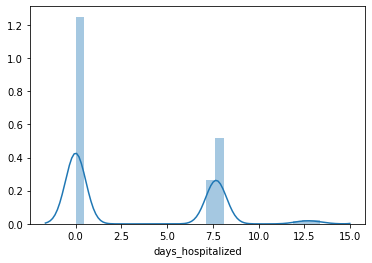

In [37]:
sns.distplot(test.days_hospitalized)